In [1]:
from torchvision import models
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import torchvision

%matplotlib inline

Vitali Petsiuk, Abir Das et. al., RISE: Randomized Input Sampling for Explanation of Black-box Models,BMVC, 2018
The original implementation by the authors is available at: https://github.com/eclique/RISE

Problem Statement: Given a trained Network and a test image, 
find the region where the network attends to make its predictions

Input: Trained Network, Input Image, class label
Output: Saliency map for the given image for the given class label

In [2]:
#### Read Image and Preprocess it ##########
transform = transforms.Compose([
                                 transforms.ToTensor(),                     
                                 transforms.Normalize(  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
                            ])


###### Read image #######
img = Image.open("catdog.png")
#img = Image.open("pup-and-kit.jpg")


img = img.resize((224,224)) 
img_cpy=np.array(img.getdata()).reshape(img.size[0], img.size[1], 3) # from PIL to numpy array


img= transform(img)
print(img.shape)
img = torch.unsqueeze(img, 0) # add an extra dimension for batch
print(img.shape)

device='cpu'

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [3]:
################### Load an Image-net pre-trained model #####################
#model = models.alexnet(pretrained=True)
#model=models.squeezenet(pretrained=True)
#model=models.resnet18(pretrained=True)
#model=models.vgg11(pretrained=True)

model=models.resnet50(pretrained=False)

checkpoint = torch.load('resnet50_pre_trained.pt')
model.load_state_dict(checkpoint['model_state_dict'])
del checkpoint

print(model)

model.to(device)
img=img.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [4]:
# torch.save({'model_state_dict': model.state_dict()}, 'resnet50_pre_trained.pt')

In [5]:
###### Put the model to the inference mode 
#(Some layers such as BatchNorm, Dropout have diff behaviour during training and inference)
model.eval()

# Perform prediction
out = model(img)
print(out.shape)

torch.Size([1, 1000])


In [6]:
with open('imagenet_classes.txt') as f:
  classes = [line for line in f.readlines()]

In [7]:
print(classes[1])

goldfish, Carassius auratus



In [8]:
########### Get the class names and confidence from the prediction vector
# Load labels
#  a.  readlines() method returns a list containing each line in the file as a list item.

#  b. strip() method returns a copy of the string with both leading and trailing characters removed 
#(in our case) '\n' at the end of each line
with open('imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]



_, idx = torch.sort(out, descending=True) # the indices sorted in the order of scores
idx = idx[0].detach().numpy()
nrmlzd_score = torch.nn.functional.softmax(out, dim=1)[0] # (bsz, ftr_dim)
nrmlzd_score=nrmlzd_score.detach().numpy()

for i in range(0,5):
    print('Class index: '+str(idx[i])+' Class Name: '+str(classes[idx[i]])+' normalized Score: '+str(nrmlzd_score[idx[i]]))

Class index: 243 Class Name: bull mastiff normalized Score: 0.38420382
Class index: 282 Class Name: tiger cat normalized Score: 0.16826774
Class index: 242 Class Name: boxer normalized Score: 0.094122626
Class index: 281 Class Name: tabby, tabby cat normalized Score: 0.059125297
Class index: 539 Class Name: doormat, welcome mat normalized Score: 0.049711227


![title](RISE_overview.png)

Step1: Mask Generation (See Section 3.2 of the BMVC paper)

1) Sample a smaller binary masks of size s by s called "grid". 
    a. How? Each pixel is randomly set to 1 with probability p and 0 with remaining probability. 

2) Upsample the images to larger resolution using bilinear interpolation. After interpolation, masks M[i] are no longer binary, but have values in [0, 1].
    
3) Translate each Mask by a random number of pixels in both spatial directions to induce more diversity in the masks.

Why are the masks generated in two stages?
Bilinear upsampling does not introduce sharp edges in I.M[i] as well as results in a smooth importance map S. 



Parameters :
N: Number of masks
s= size of the initially generated smaller masks
p1= probability with which is pixel is set to 1.
size of mask=size of the input image

In [9]:
def generate_masks(N, s, p1, img_sz):
    
    ############################ 
    # P1 will control sparsity of the masks
    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')
    masks = np.empty((N, *img_sz)) # initialize the masks as empty
    
    mx_shft = np.ceil(np.array(img_sz) / s)
    up_size = (s + 1) * mx_shft
    
    for i in range(N):
        # Random shifts
        x = np.random.randint(0, mx_shft[0])
        y = np.random.randint(0, mx_shft[1])
        # Linear upsampling and cropping
        tmp = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)
        masks[i,:,:]=tmp[x:x + img_sz[0], y:y + img_sz[1]]
    
    
    masks=np.expand_dims(masks, axis=1) # Converts size from (N,H,W) to (N,1,H,W)
    return masks



def compute_predictions(model, masked, batch_sz, cls_idx,N):
    
    preds_lst=[]
    for i in range(0, N, batch_sz):
        pred=model(masked[i:min(i+batch_sz, N)])
        
        pred=pred.to('cpu')
        pred=pred.detach().numpy()
        pred=pred[:,cls_idx]
        preds_lst.append(pred)
        
    preds_lst = np.concatenate(preds_lst)
    return preds_lst





def RISE_explain(masks, img, model, cls_idx, p1):
    masked = img * masks 
    print("image shape: "+ str(img.shape))
    print("mask shape: " +str(masks.shape))
    print("masked image shape: "+str(masked.shape))
    
    N=masked.shape[0]
    ht=masked.shape[2]
    wdth=masked.shape[3]
    
    batch_sz=16
    preds=compute_predictions(model, masked, batch_sz, cls_idx, N)
    print('Predictions Shape : '+str(preds.shape))
    
    # convert masks to cpu
    masks=masks.to('cpu').numpy()
    
    masks=np.reshape(masks, (N,-1), order='C') 
    sal = (preds.T).dot(masks) # preds.T is (1,N)  and masks is (N,H*W).  So Sal is (1,H*W)
    
    ### What if our cls_idx was a vector of dim C->  Sal (C,H*W)
    
    sal=sal.reshape(-1, ht, wdth)
    
    sal = sal / N / p1
    
    
    
    return sal
    


(2000, 1, 224, 224)


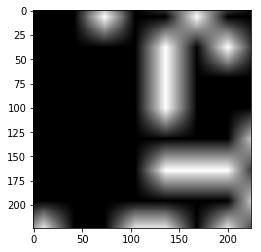

In [10]:
masks=generate_masks(N=2000, s=8, p1=0.2, img_sz=(224, 224))
print(masks.shape)

plt.imshow(np.squeeze(masks[10,:,:,:]), cmap='gray', vmin=0, vmax=1)

# Convert masks from numpy to pytorch tensors
masks=torch.from_numpy(masks)
masks=masks.float()
masks=masks.to(device)


image shape: torch.Size([1, 3, 224, 224])
mask shape: torch.Size([2000, 1, 224, 224])
masked image shape: torch.Size([2000, 3, 224, 224])
Predictions Shape : (2000,)


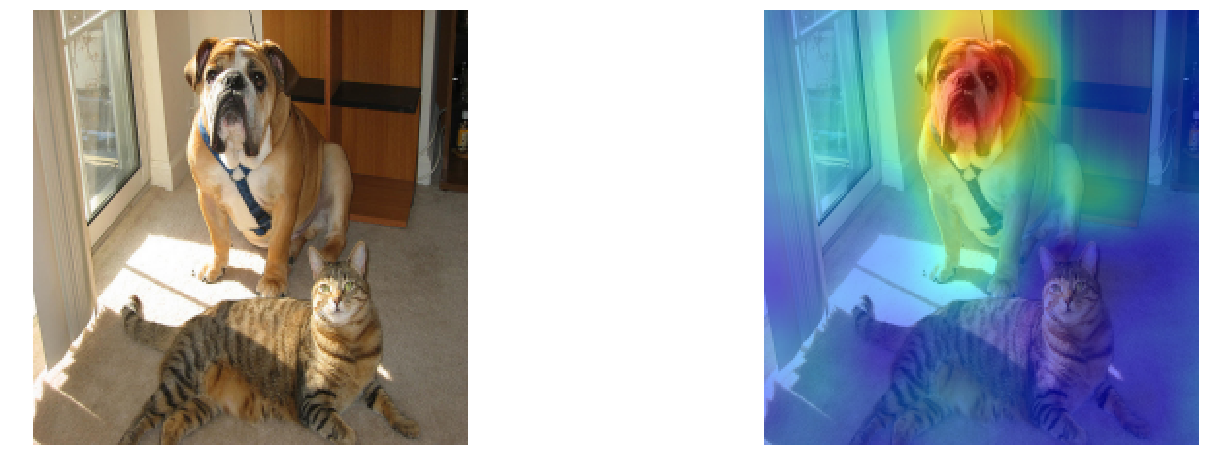

In [11]:
# Make sure multiplication is being done for correct axes
sal=RISE_explain(masks, img, model, 242, 0.1)

plt.figure(figsize=(24, 8))
plt.subplot(121)
plt.axis('off')

plt.imshow(img_cpy)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_cpy)
plt.imshow(np.squeeze(sal), cmap='jet', alpha=0.5)

plt.show()

image shape: torch.Size([1, 3, 224, 224])
mask shape: torch.Size([2000, 1, 224, 224])
masked image shape: torch.Size([2000, 3, 224, 224])
Predictions Shape : (2000,)


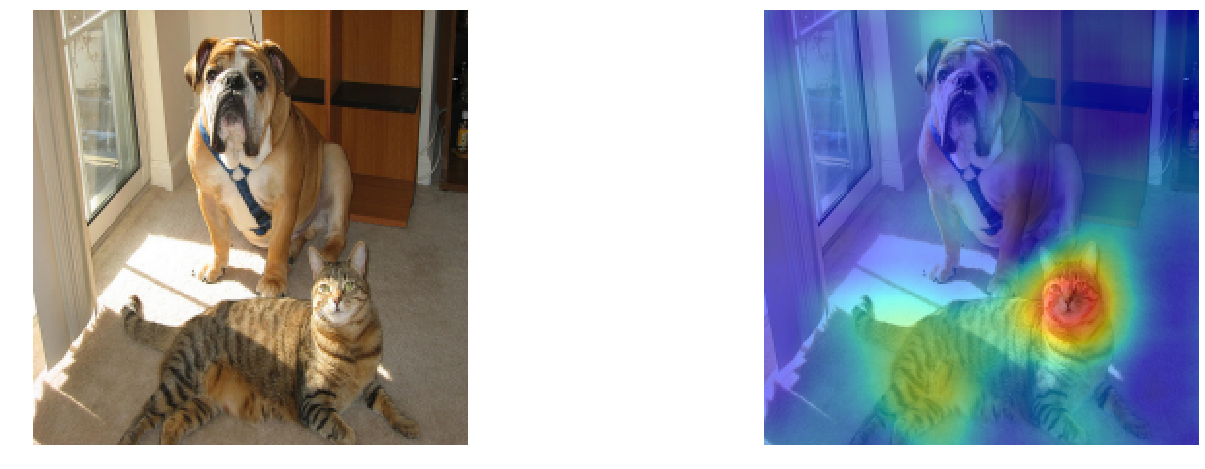

In [12]:
sal=RISE_explain(masks, img, model, 282, 0.1)
#sal=RISE_explain(masks, img, model, 283, 0.1)

plt.figure(figsize=(24, 8))
plt.subplot(121)
plt.axis('off')

plt.imshow(img_cpy)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_cpy)
plt.imshow(np.squeeze(sal), cmap='jet', alpha=0.5)

plt.show()